<a href="https://colab.research.google.com/github/MIlhamEr/Skripsi/blob/main/GRU_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reading Dataset

## ADRO

In [ ]:
url_adro = "https://raw.githubusercontent.com/MIlhamEr/Skripsi/refs/heads/main/dataset/PT%20Adaro%20Energy%20Indonesia%20Tbk_2020-2024.csv"
adro = pd.read_csv(url_adro)
adro.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,1555.0,1555.0,1490.0,1495.0,835.632202,76612000
1,2020-01-03,1460.0,1470.0,1425.0,1465.0,856.372375,117795600
2,2020-01-06,1455.0,1515.0,1450.0,1465.0,856.372375,61423200
3,2020-01-07,1480.0,1540.0,1460.0,1540.0,900.213867,74336500
4,2020-01-08,1530.0,1535.0,1505.0,1505.0,879.754395,55121100


In [ ]:
adro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1148 non-null   object 
 1   Open       1148 non-null   float64
 2   High       1148 non-null   float64
 3   Low        1148 non-null   float64
 4   Close      1148 non-null   float64
 5   Adj Close  1148 non-null   float64
 6   Volume     1148 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 62.9+ KB


## DSSA

In [ ]:
url_dssa = "https://raw.githubusercontent.com/MIlhamEr/Skripsi/refs/heads/main/dataset/PT%20Dian%20Swastatika%20Sentosa%20Tbk_2020-2024.csv"
dssa = pd.read_csv(url_dssa)
dssa.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,1360.0,1435.0,1360.0,1435.0,1435.0,5000
1,2020-01-03,1435.0,1435.0,1435.0,1435.0,1435.0,0
2,2020-01-06,1437.5,1437.5,1435.0,1435.0,1435.0,3000
3,2020-01-07,1435.0,1435.0,1435.0,1435.0,1435.0,0
4,2020-01-08,1435.0,1435.0,1435.0,1435.0,1435.0,0


In [ ]:
dssa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1148 non-null   object 
 1   Open       1148 non-null   float64
 2   High       1148 non-null   float64
 3   Low        1148 non-null   float64
 4   Close      1148 non-null   float64
 5   Adj Close  1148 non-null   float64
 6   Volume     1148 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 62.9+ KB


# Pre-processing Data

## Cleaning Dataset

In [ ]:
adro_missing = adro.isnull().sum()
dssa_missing = dssa.isnull().sum()

print("Missing values in ADRO:")
print(adro_missing)
print("\nMissing values in DSSA:")
print(dssa_missing)

Missing values in ADRO:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Missing values in DSSA:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


## Normalisasi Data

*   Normalisasi data pake MinMaxScaler
*   Kolom Date Ga dipake

In [ ]:
scaler = MinMaxScaler()

In [ ]:
def normalize_data(df):
    scaled_df = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=df.columns[1:], index=df.index)
    return scaled_df

In [ ]:
adro_norm = adro.copy()
adro_norm = normalize_data(adro_norm)

In [ ]:
dssa_norm = dssa.copy()
dssa_norm = normalize_data(dssa_norm)

In [ ]:
adro_norm.head()

,Open,High,Low,Close,Adj Close,Volume
0,0.260372,0.247207,0.253602,0.243205,0.129805,0.141875
1,0.233190,0.223464,0.234870,0.234621,0.135675,0.218142
2,0.231760,0.236034,0.242075,0.234621,0.135675,0.113748
3,0.238913,0.243017,0.244957,0.256080,0.148084,0.137661
4,0.253219,0.241620,0.257925,0.246066,0.142293,0.102077


In [ ]:
dssa_norm.head()

,Open,High,Low,Close,Adj Close,Volume
0,0.010859,0.011743,0.011073,0.012575,0.012575,0.000417
1,0.012669,0.011743,0.012918,0.012575,0.012575,0.000000
2,0.012729,0.011800,0.012918,0.012575,0.012575,0.000250
3,0.012669,0.011743,0.012918,0.012575,0.012575,0.000000
4,0.012669,0.011743,0.012918,0.012575,0.012575,0.000000


# Data Mining

## Windowing (Time Series Data)

Model GRU memerlukan data time series, jadi kita perlu membuat window (misalnya 30 hari ke belakang untuk memprediksi harga di hari ke-31).


In [ ]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps -1): # Fixed : Subtracted 1 to avoid index error
        X.append(data.iloc[i:i+time_steps].values) # Changed: use iloc to access rows and convert to NumPy array
        y.append(data.iloc[i+time_steps, 0])       # Changed: use iloc to access row and column by index
    return np.array(X), np.array(y)

# ADRO


In [ ]:
time_steps = 30
X, y = create_sequences(adro_norm, time_steps)

## Target Attribute

Dipilih atribut "high" sebagai target prediksi

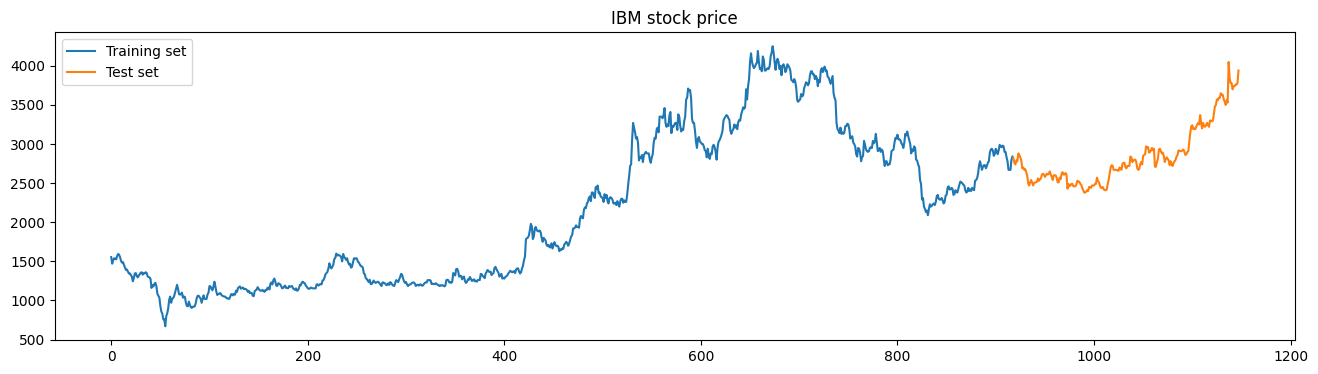

In [ ]:
adro["High"][:918].plot(figsize=(16,4),legend=True)
adro["High"][918:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title('IBM stock price')
plt.show()

## Pembagian Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Model GRU

In [ ]:
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Output layer with 1 neuron for regression
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 30, 50)              │           8,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,051 (93.95 KB)

 Trainable params: 24,051 (93.95 KB)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0721 - val_loss: 3.2734e-04
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0066 - val_loss: 3.4180e-04
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0065 - val_loss: 9.0661e-04
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0050 - val_loss: 2.9810e-04
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0036 - val_loss: 3.2498e-04
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0037 - val_loss: 3.8213e-04
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0037 - val_loss: 2.9912e-04
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0034 - val_loss: 2.9416e-04
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0030 - val_loss: 2.6246e-04
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0029 - val_loss: 2.4451e-04
Epoch 12/50
26/26 ━━━━━

## Plot training history

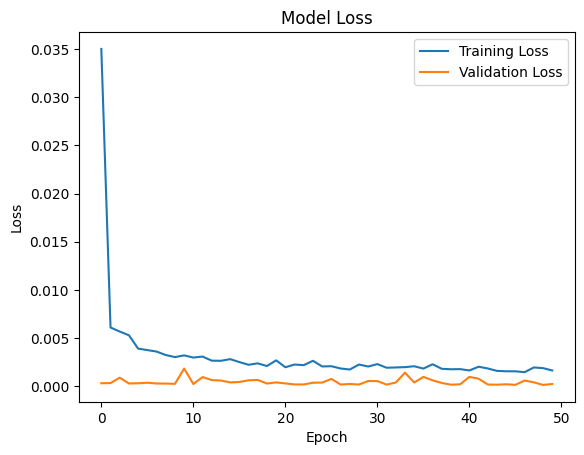

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## Prediction

In [ ]:
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 


## Evaluation Metrics

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.3f}')
print(f'MAPE: {mape:.3f}%')
print(f'R-squared: {r2:.5f}')

RMSE: 0.018
MAPE: 17.295%
R-squared: 0.97200


## Inverse Transform

In [ ]:
y_pred = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), adro_norm.shape[1] - 1))), axis=1))[:,0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.zeros((len(y_test), adro_norm.shape[1] - 1))), axis=1))[:,0]

## Plot the predicted vs actual values

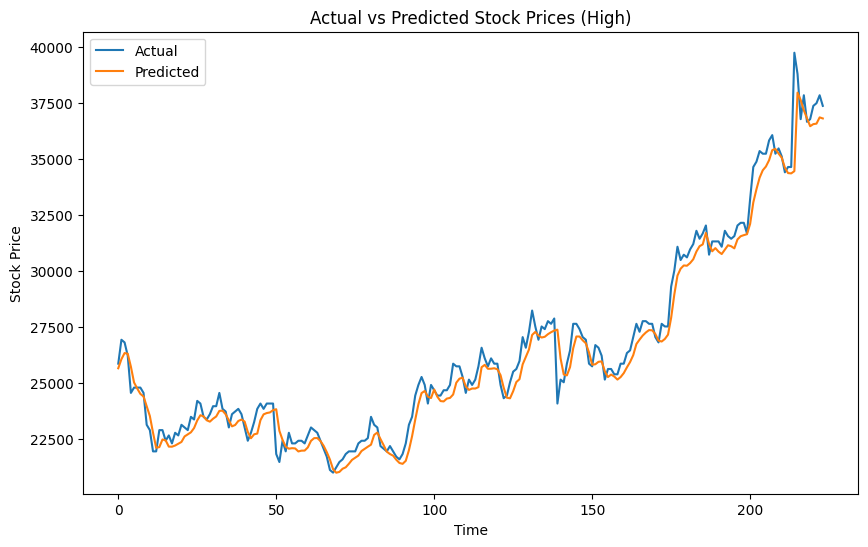

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Stock Prices (High)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# DSSA

In [ ]:
time_steps = 30
X, y = create_sequences(dssa_norm, time_steps)

## Target Attribute

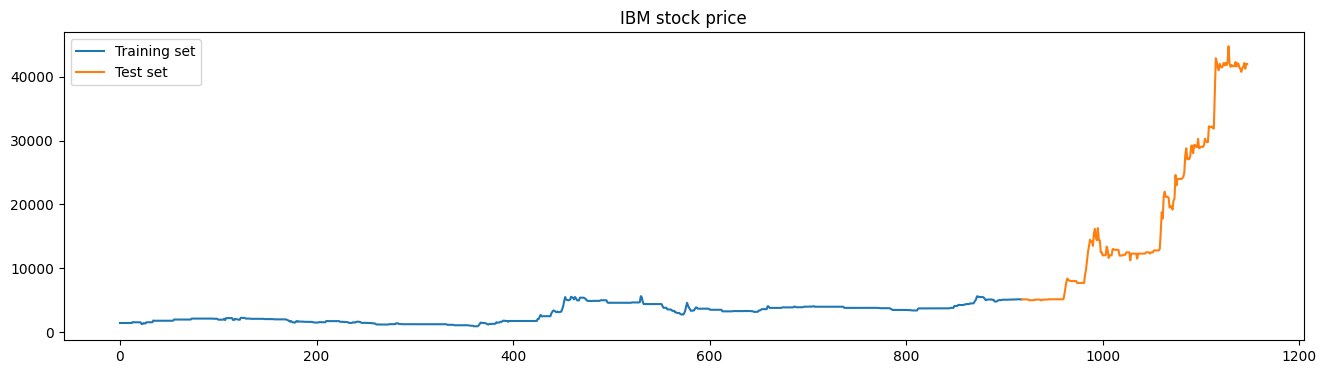

In [ ]:
dssa["High"][:918].plot(figsize=(16,4),legend=True)
dssa["High"][918:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title('IBM stock price')
plt.show()

##Pembagian Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Model GRU

In [ ]:
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Output layer with 1 neuron for regression
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 30, 50)              │           8,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,051 (93.95 KB)

 Trainable params: 24,051 (93.95 KB)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop])

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 0.0011 - val_loss: 1.1830e-04
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 8.5305e-05 - val_loss: 6.7533e-05
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 4.6594e-05 - val_loss: 3.5711e-05
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 5.1520e-05 - val_loss: 3.1756e-05
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 5.3599e-05 - val_loss: 1.5683e-05
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 4.3037e-05 - val_loss: 5.9313e-05
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 5.2022e-05 - val_loss: 2.7531e-05
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 3.0969e-05 - val_loss: 3.9970e-05
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 4.1027e-05 - val_loss: 3.6477e-05
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.2069e-05 - val_loss: 4.5365e-05
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.4078e-05 -

## Plot training history

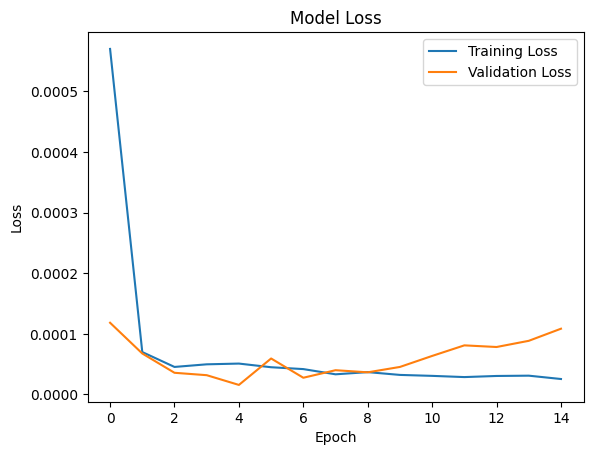

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

##Prediction

In [ ]:
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


## Evaluation Metrics

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.3f}')
print(f'MAPE: {mape:.3f}%')
print(f'R-squared: {r2:.5f}')

RMSE: 0.043
MAPE: 110.894%
R-squared: 0.97850


## Inverse Transform

In [ ]:
y_pred = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), adro_norm.shape[1] - 1))), axis=1))[:,0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.zeros((len(y_test), adro_norm.shape[1] - 1))), axis=1))[:,0]

## Plot the predicted vs actual values

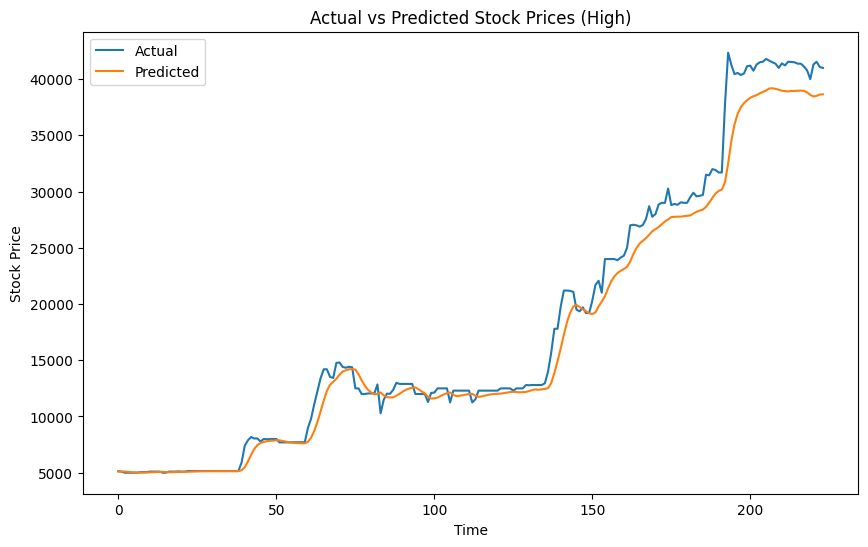

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Stock Prices (High)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()